# CCA SSVEP dataset

In [1]:
import numpy as np
import pandas as pd
import pywt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.fftpack
from scipy import stats, integrate
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt

from sklearn.cross_decomposition import CCA
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline

## Load Data

In [2]:
# load and sort the paths
path = '../data/raw/'
sampling_rate = 128

fnames = glob(path+'*.csv') # get paths and save them
fnames = [ '../data/raw/alebs-record.csv',
 '../data/raw/barlo-record.csv',
 '../data/raw/yagmur-record.csv']
fnames.sort()

In [3]:
electrodes_names = ['Time','AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'label']
aleks2 = {}
aleks2 = pd.read_csv('../data/raw/alebs-2-record.csv', names=electrodes_names)

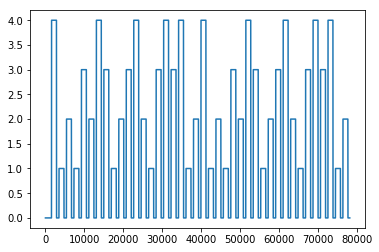

In [4]:
plt.plot(aleks2.label)

## Applying Bandpass Filter on One Channel

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return filtfilt(b, a, data) 

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
aleks2_filt = pd.DataFrame()

for col in aleks2.columns.tolist():
    aleks2_filt[col] = butter_bandpass_filter( aleks2[col], 5, 20, sampling_rate)

aleks2_filt.label = aleks2.label
aleks2_filt.Time = aleks2.Time
aleks2_filt.head(2)

,Time,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label
0,0.000000,10.215994,10.228524,10.243309,10.297939,10.494405,10.300946,10.452806,10.257092,10.265111,10.114754,10.210481,10.256340,10.173393,10.239801,0
1,0.007812,78.546269,78.628800,78.754730,79.150601,80.692626,79.185494,80.350060,78.843885,78.888736,77.821932,78.559523,78.848381,78.227072,78.725506,0


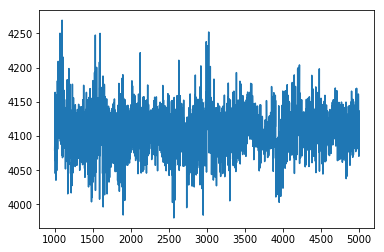

In [7]:
plt.plot(aleks2.AF3[1000:5000]);

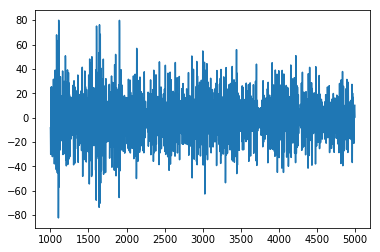

In [8]:
plt.plot(aleks2_filt.AF3[1000:5000]);

## Epochs

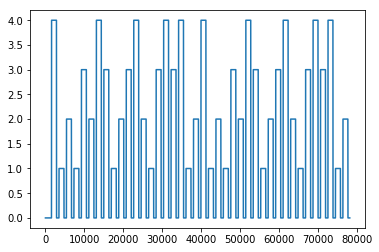

In [9]:
plt.plot(aleks2.label)

### Get Points Needed For Epochs

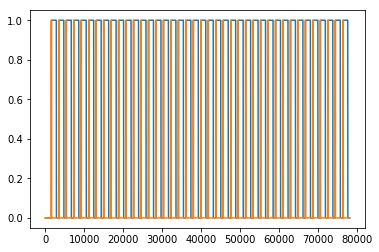

In [10]:
threshold = 0.5

idxOFF = np.argwhere(aleks2.label < threshold)
idxON = np.argwhere(aleks2.label > threshold)


x_alwaysON = np.zeros(len(aleks2.index))
x_alwaysON[idxON] = 1

x_turnON = np.roll(x_alwaysON, 1)
x_turnON = x_alwaysON - x_turnON
x_turnON = np.where(x_turnON > 0, x_turnON, 0)

plt.plot(x_alwaysON)
plt.plot(x_turnON)
plt.show()

In [11]:
y = np.zeros(len(np.argwhere(x_turnON)))
i = 0
for n in np.argwhere(x_turnON):
    y[i] = aleks2.label[n]
    i+=1
y

array([4., 1., 2., 1., 3., 2., 4., 3., 1., 2., 3., 4., 2., 1., 3., 4., 3.,
       4., 1., 2., 4., 1., 2., 1., 3., 2., 4., 3., 1., 2., 3., 4., 2., 1.,
       3., 4., 3., 4., 1., 2.])

### Pick Only Needed Electrodes

In [12]:
picked_electrodes = {'AF3', 'F3', 'AF4', 'F4', 'F7', 'F8'}

data_electr_filt = np.zeros((aleks2_filt.shape[0], len(picked_electrodes)))


for n, elec in enumerate(picked_electrodes):
    data_electr_filt[:,n] = aleks2_filt[elec]

data_electr_filt.shape

(78208, 6)

### Epoching over all data
epochs = num trials x num data points x num electrodes
epochs concat = trials\*electrodes x data points

In [13]:
N_epoch = 1000
epochs = np.zeros((len( np.argwhere(x_turnON) ),N_epoch, len(picked_electrodes))) #34x700x4 

for n, i in enumerate(np.argwhere(x_turnON)):  
    epochs[n,:,:] = data_electr_filt[i[0]:i[0]+N_epoch,:]
    

In [14]:
epochs.shape

(40, 1000, 6)

# Spectograms 

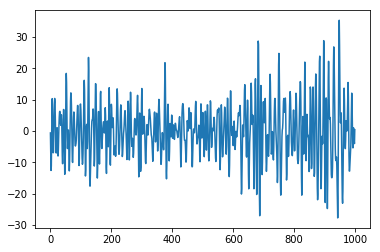

In [15]:
sample = epochs[1,:,2]
plt.plot(sample);

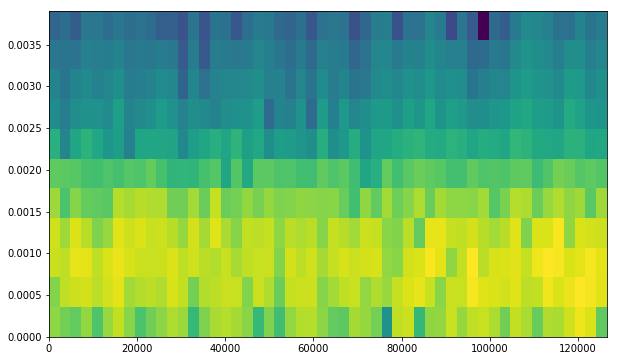

In [16]:
sample = epochs[1,:,2]

plt.figure(figsize=(10,6))
plt.specgram(sample, NFFT=20, Fs=1/sampling_rate, noverlap=1);

4.0


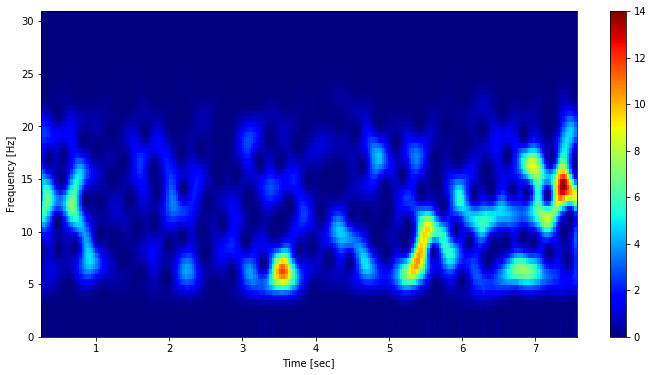

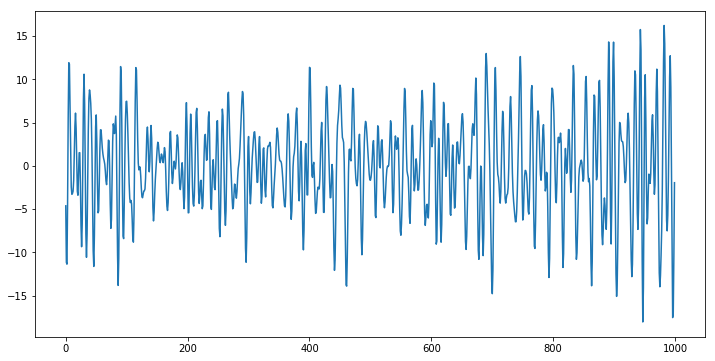

In [17]:
n=31
sample = epochs[n,:,1]
print(y[n])
f, t, Sxx = signal.spectrogram(sample.T, sampling_rate, nfft=256, nperseg=64,
                              window=('hamming'), noverlap=60)

plt.figure(figsize=(12,6))
plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,31)
plt.colorbar()

plt.figure(figsize=(12,6))
plt.plot(sample);


4.0


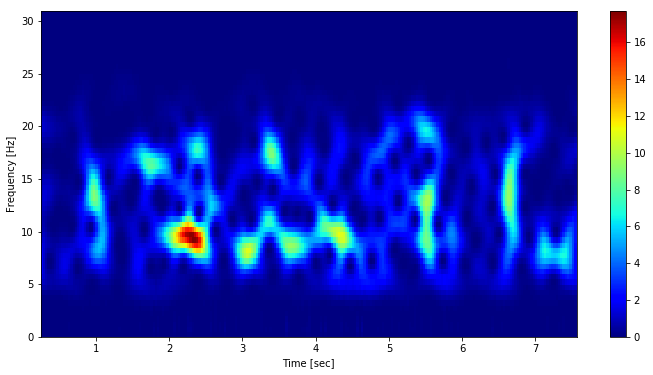

In [30]:
n=17
print(y[n])
F = np.zeros(129)

for i in np.arange(0,6):
    sample = epochs[n,:,i]
    f, t, Sxx = signal.spectrogram(sample.T, sampling_rate, nfft=256, nperseg=64,
                              window=('hamming'), noverlap=60)
    F += f/6

F=F
plt.figure(figsize=(12,6))
plt.pcolormesh(t, F, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,31)
plt.colorbar();
plt.savefig('powerspec_alebs3.jpg', dpi=200, bbox_inches='tight', transparent="True", pad_inches=0 )

1.0


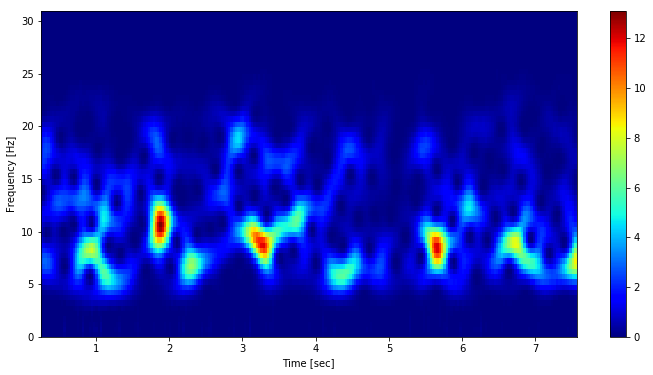

In [29]:
n=23
print(y[n])
F = np.zeros(129)

for i in np.arange(0,6):
    sample = epochs[n,:,i]
    f, t, Sxx = signal.spectrogram(sample.T, sampling_rate, nfft=256, nperseg=64,
                              window=('hamming'), noverlap=60)
    F += f/6

F=F
plt.figure(figsize=(12,6))
plt.pcolormesh(t, F, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,31)
plt.colorbar();
plt.savefig('powerspec_alebs4.jpg', dpi=200, bbox_inches='tight', transparent="True", pad_inches=0 )

4.0
1.0
2.0
1.0
3.0
2.0
4.0
3.0
1.0
2.0
3.0
4.0
2.0
1.0
3.0
4.0
3.0
4.0
1.0
2.0
4.0


/home/ateska/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1.0
2.0
1.0
3.0
2.0
4.0
3.0
1.0
2.0
3.0
4.0
2.0


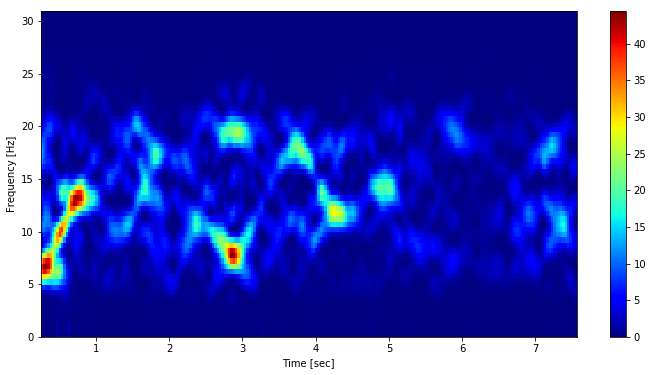

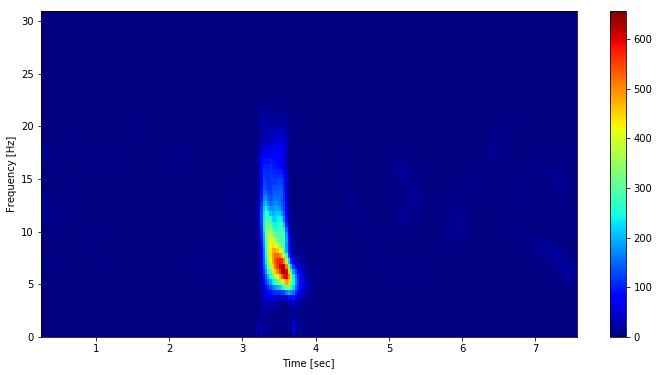

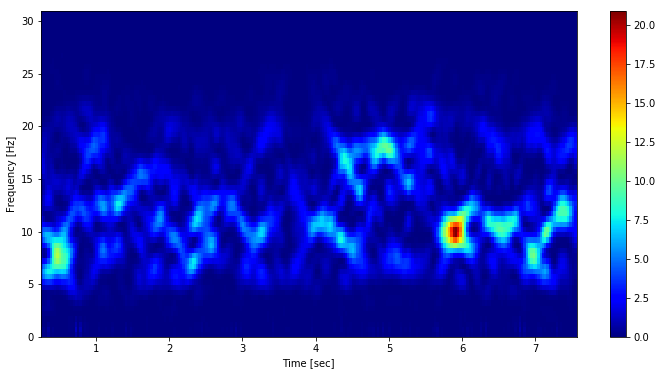

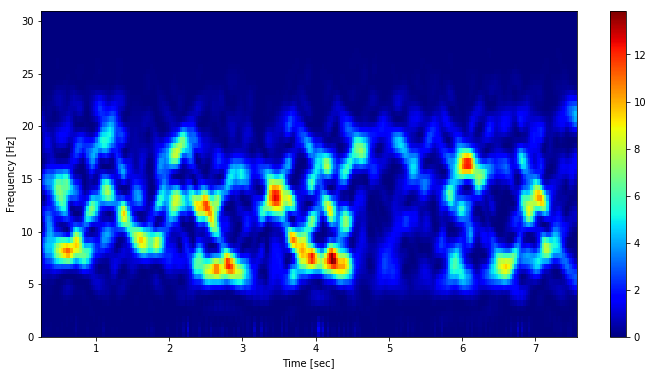

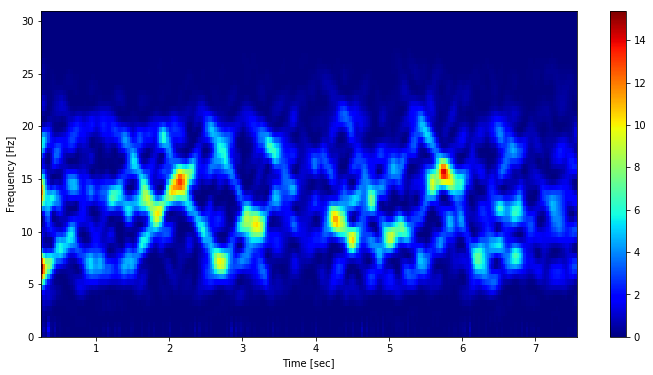

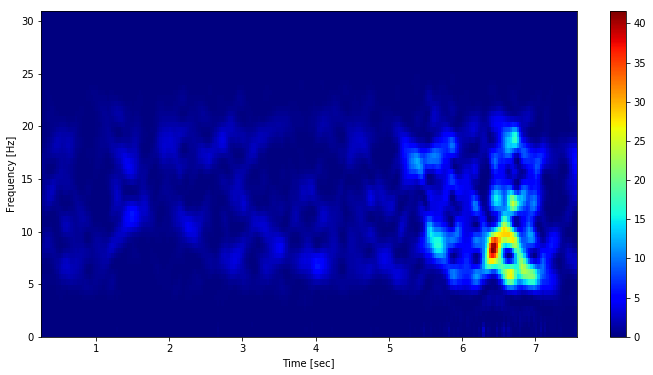

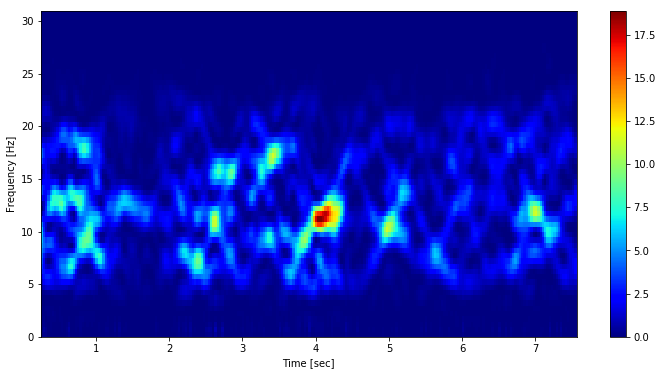

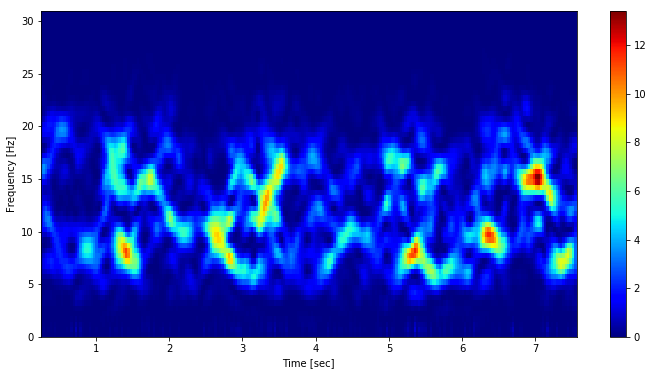

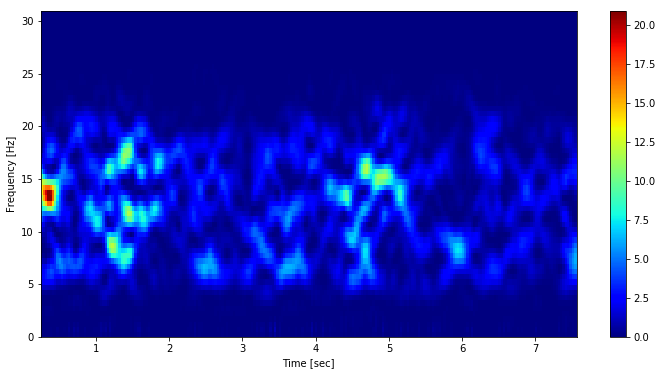

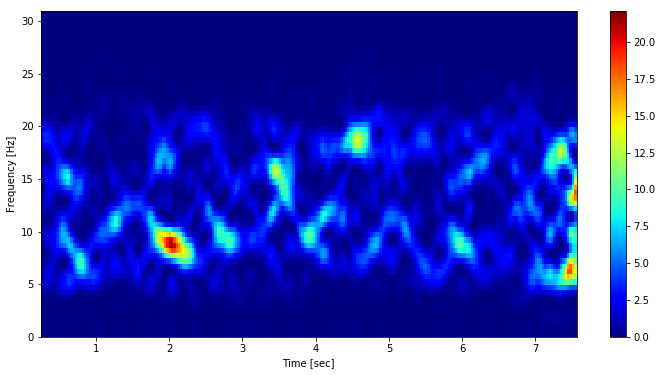

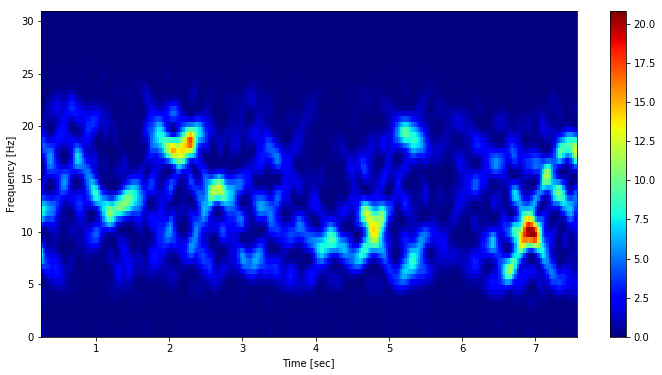

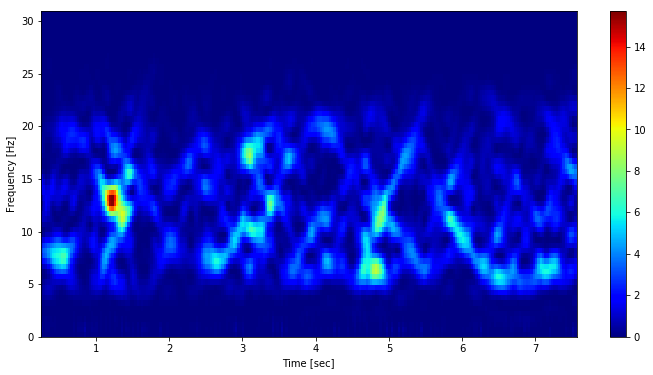

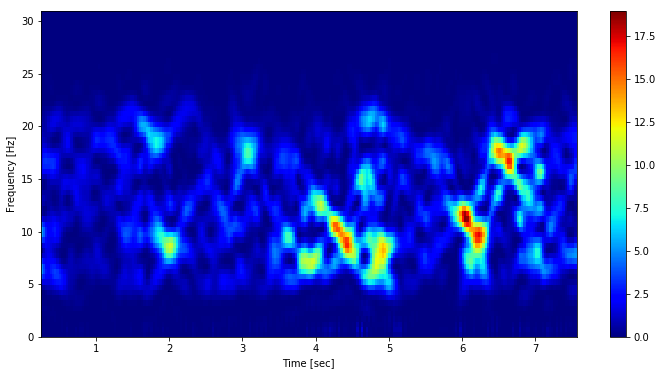

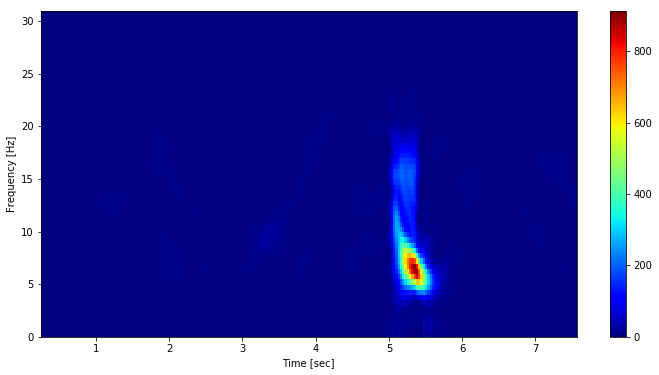

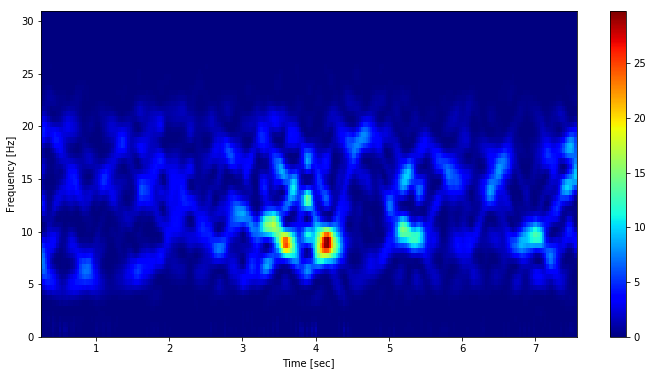

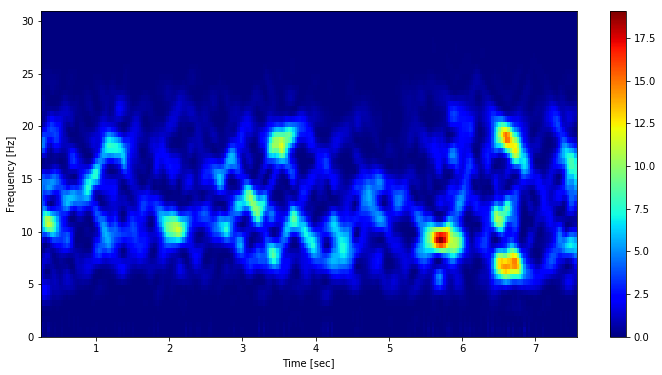

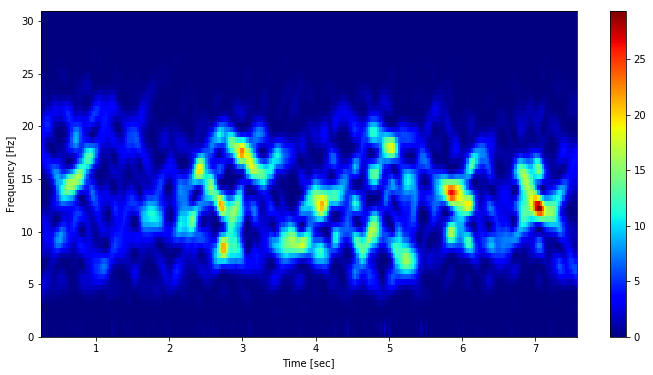

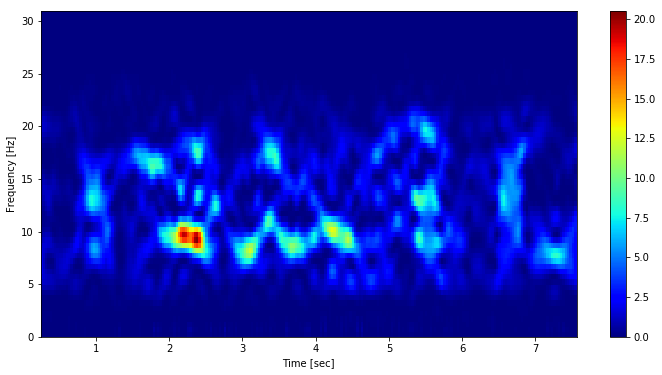

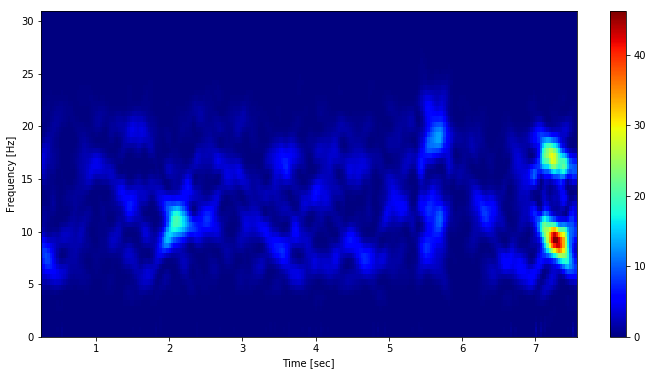

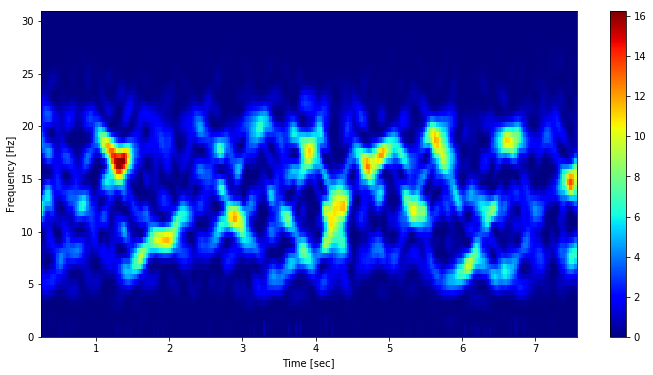

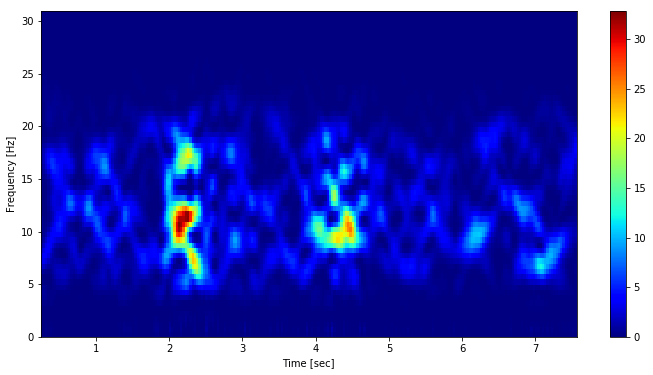

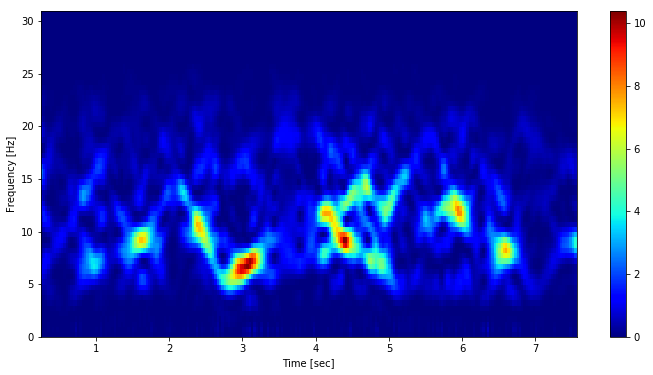

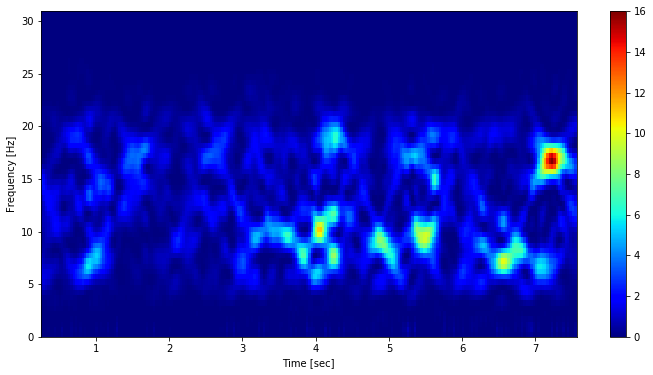

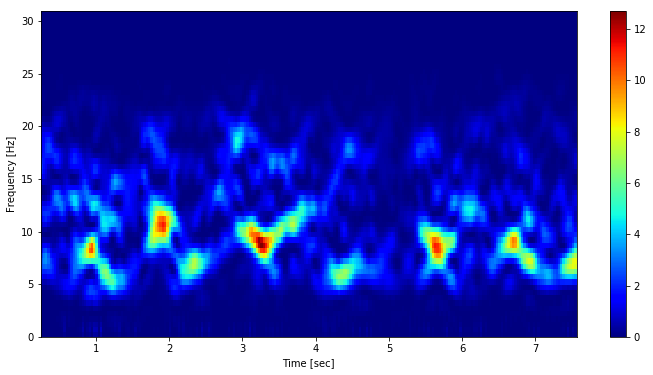

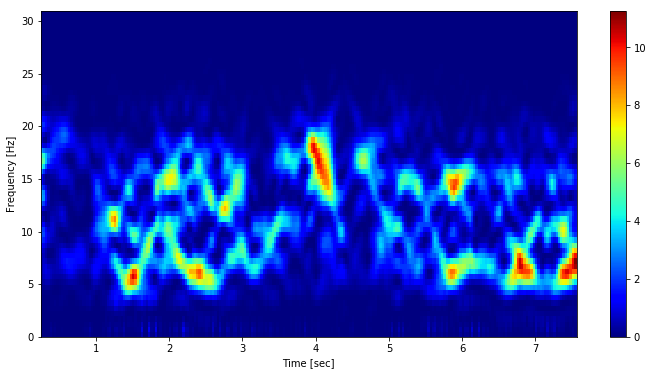

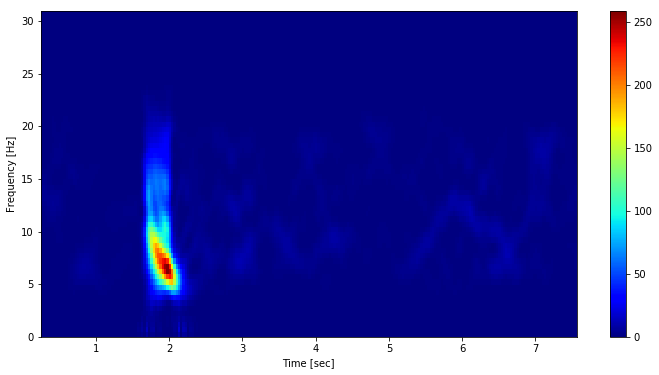

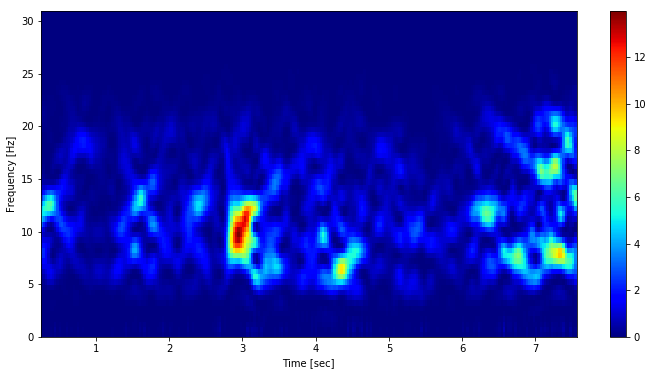

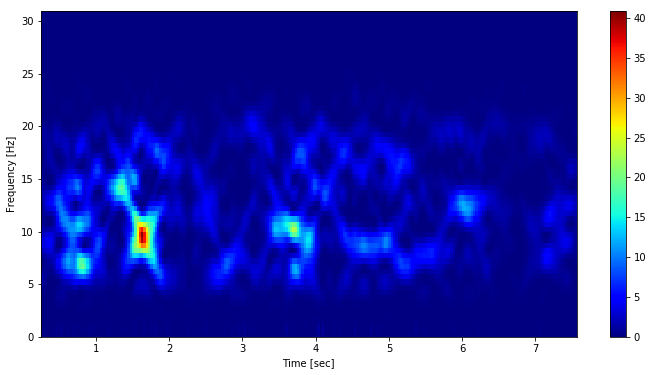

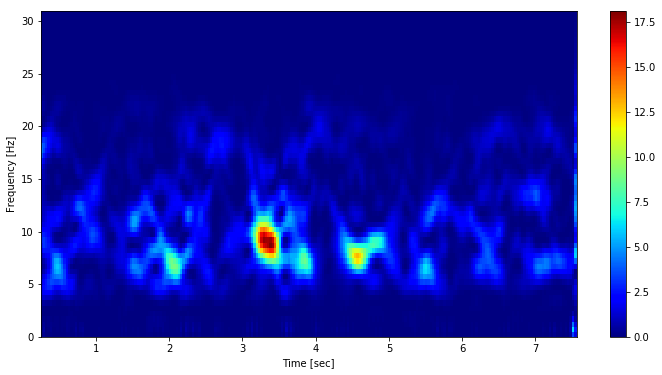

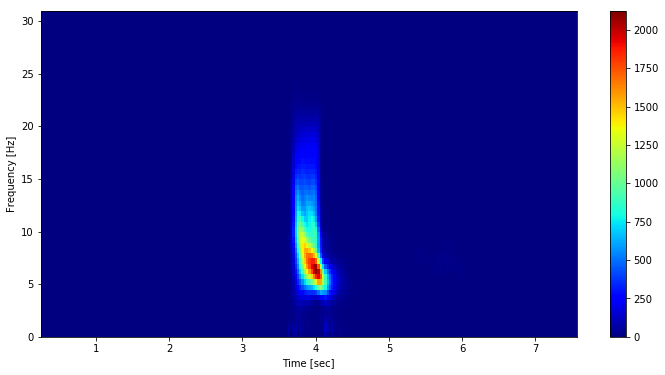

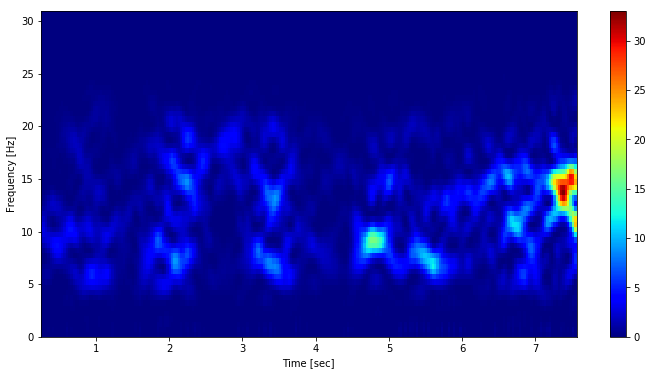

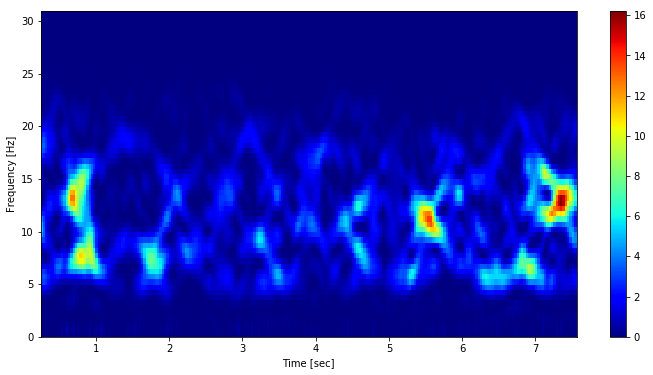

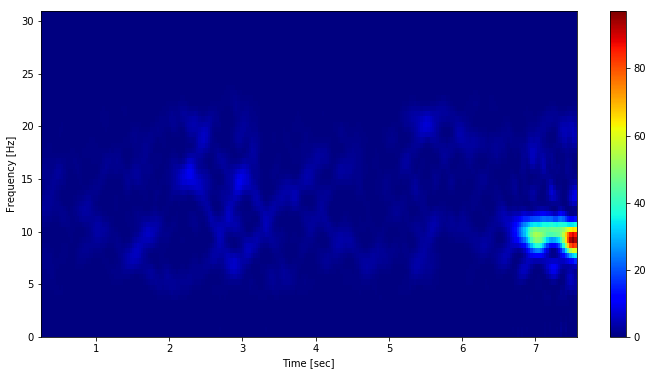

In [19]:
for n in np.arange(0,33):

    F = np.zeros(129)

    for i in np.arange(0,6):
        sample = epochs[n,:,i]
        f, t, Sxx = signal.spectrogram(sample, sampling_rate, nfft=256, nperseg=64,
                                  window=('tukey', 0.5),
                                  noverlap=60
                                    )
        F += f/6

    F=F
    print(y[n])
    
    plt.figure(figsize=(12,6))
    plt.pcolormesh(t, F, Sxx, cmap='jet')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0,31)
    
    plt.colorbar();

In [20]:
# signal.spectrogram?

In [21]:
# signal.get_window?

# Spectrum Visualization

In [22]:
def single_sided_spectrum(signal, sample_rate):
    # compute discrete FT and normalize with signal length
    spectrum = abs(np.fft.fft(signal)) / len(signal)
    spec_freq = np.fft.fftfreq(signal.shape[-1], d=1 / sample_rate)
    half = int(len(spectrum)/2)

    # the first half of the spectrum contains the part for positive frequencies
    pos_spectrum = spectrum[:half]
    # and the second half for negative frequencies
    # neg_spectrum = np.flip(spectrum[half:], axis=0)
    # add them up to get the single sided spectrum
    single_sided = 2 * pos_spectrum

    return single_sided, spec_freq[:half]

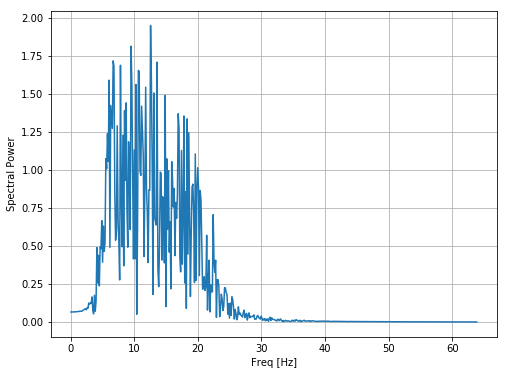

In [23]:
sample = epochs[2,:,2]
spec, freq = single_sided_spectrum(sample, sampling_rate)

plt.figure(figsize=(8,6))
plt.plot(freq, spec);
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('Spectral Power')
plt.grid()

4.0


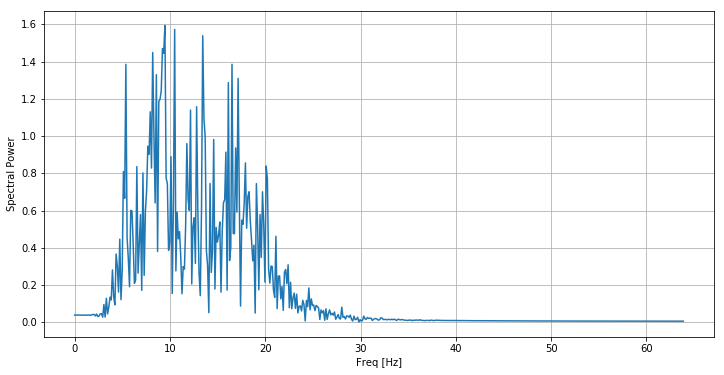

In [37]:
n=17
print(y[n])
F = np.zeros(500)


for i in np.arange(0,6):
    sample = epochs[n,:,i]
    spec, freq = single_sided_spectrum(sample, sampling_rate)
    F += freq

F=F/6
plt.figure(figsize=(12,6))
plt.xlabel('Freq [Hz]')
plt.ylabel('Spectral Power')
plt.grid()
plt.plot(F, spec);
plt.savefig('alebs3.jpg', dpi=200, bbox_inches='tight', transparent="True", pad_inches=0 )